# Visual and Data Analysis - FIFA 19 Players
- **Created by Andrés Segura Tinoco**
- **Created on May 20, 2019**

# 5. Analysis of Similarity
## Loading main libraries and data

In [1]:
# Load the Pandas libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import OrderedDict

In [2]:
# Load Similarity libraries
from scipy import stats as ss
import sklearn.metrics.pairwise as sm

In [3]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Read FIFA 19 players data only using the current skill values
dataURL = "https://raw.githubusercontent.com/ansegura7/DataScience_FIFA19Data/master/data/fifa19_overall_data.csv"
rawdata = pd.read_csv(dataURL)
print(rawdata.shape)

(18207, 89)


In [5]:
# Function that obtains the numerical data from the data frame
def getNumericalData(data, quality):
    numData = pd.DataFrame()
    
    # Create DataFrame
    for col in data.columns:
        if str(data[col].dtype) != "object":
            numData[col] = data[col]
    
    # Remove columns that are not relevant for the analysis
    nonColumns = ["Order", "ID", "Overall", "Potential", "Value €", "Wage €", "Release Clause €"]
    numData = numData.drop(nonColumns, axis=1)
    
    # Data Quality process
    if quality and len(numData.columns) > 0:
        numData = numData.fillna(numData.mean())
    
    print(numData.shape)
    return numData;

In [6]:
# Set an Overall threshold
threshold = 80
threshold

80

In [7]:
# Filter/Delete player with an overall below the threshold
rawdata = rawdata.loc[rawdata["Overall"] >= threshold]
len(rawdata)

555

In [8]:
# Get only numeric columns/variables
numData = getNumericalData(rawdata, True)
numData.head()

(555, 68)


,Age,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,HeightMts,WeightLbs,LS,ST,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,2202,5.0,4.0,4.0,10.0,1.70,159.0,88,88,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,2228,5.0,4.0,5.0,7.0,1.88,183.0,91,91,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,2143,5.0,5.0,5.0,10.0,1.75,150.0,84,84,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,1471,4.0,3.0,1.0,1.0,1.93,168.0,0,0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,2281,4.0,5.0,4.0,7.0,1.80,154.0,82,82,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


## Apply PCA with Standardization

In [9]:
# Function that apply Principal Component Analysis
def applyPCA(data, std):
    
    # Standardize the Data
    if std == True:
        x = StandardScaler().fit_transform(data.values)
    else:
        x = data.values
    
    # Create a DataFrame from PCA
    pca = PCA(n_components = 5)
    pcaData = pca.fit_transform(x)
    pcaDF = pd.DataFrame(data = pcaData, columns = ["PC1", "PC2", "PC3", "PC4", "PC5"])
    
    # Show the total explained variance ratio of model
    print('Explained Variance Ratio:', sum(pca.explained_variance_ratio_) * 100)
    
    return pcaDF;

In [10]:
# Apply the PCA algorithm
pcaDF = applyPCA(numData, True)

# Create the PCA data
pcaDF = pd.concat([pcaDF, rawdata[["Name"]]], axis = 1)
pcaDF = pcaDF[pcaDF["PC1"].notnull()]
pcaDF.head(10)

Explained Variance Ratio: 88.99078649524128


,PC1,PC2,PC3,PC4,PC5,Name
0,-5.526306,-5.808015,2.076504,2.350692,3.071319,L. Messi
1,-5.033655,-3.568653,4.896926,0.254852,4.140921,Cristiano Ronaldo
2,-4.986200,-5.803934,1.127417,1.682914,2.750608,Neymar Jr
3,16.489354,-1.978795,0.312424,2.100684,2.824599,De Gea
4,-6.030921,-1.962398,1.298546,2.143308,1.320396,K. De Bruyne
5,-4.936598,-4.930870,0.985261,1.042247,1.841818,E. Hazard
6,-6.034160,-1.682930,-0.712501,3.359507,1.979452,L. Modrić
7,-4.291498,-2.126353,3.635059,1.426361,2.758875,L. Suárez
8,-3.698536,3.403521,1.141814,0.939394,2.542291,Sergio Ramos
9,17.572773,-1.278344,0.143841,0.435352,2.526036,J. Oblak


## Apply Similarity Functions

In [11]:
# Returns the similarity between 2 vectors
def getSimilarity(func, x, y):
    similarity = 0
    
    if func == 'cosine':
        result = sm.cosine_similarity([x], [y])
        similarity = float(result[0])
    
    elif func == 'pearson':
        corr, p_value = ss.pearsonr(x, y)
        similarity = corr
        
    elif func == 'euclidean':
        result = sm.euclidean_distances([x], [y])
        similarity = float(result[0])
    
    elif func == 'manhattan':
        result = sm.manhattan_distances([x], [y])
        similarity = float(result[0])
    
    return similarity;

In [12]:
# Get more N similar instances
def getMoreSimilarInstances(df, func, n, target):
    solution = dict()
    simList = dict()
    currVector = df[df['Name'] == target]
    
    if (currVector is not None) and (len(currVector) > 0):
        currVector = currVector.values[0, 0:5];

        for ix, row in df.iterrows():
            currName = row['Name']
            if currName != target:
                neighVector = [row['PC1'], row['PC2'], row['PC3'], row['PC4'], row['PC5']]
                similarity = getSimilarity(func, currVector, neighVector)
                simList[currName] = similarity
                
        # Sorting dictionary in ascending order based on values
        n = min(len(simList), n)
        if n > 0:
            simList = OrderedDict(sorted(simList.items(), key = lambda kv: kv[1], reverse = True))
            ix = 0
            for key, value in simList.items():
                if ix < n:
                    solution[key] = round(value, 4)
                    ix += 1
                else:
                    break
    
    return solution;

In [13]:
# Palette by positions dictionary
posPalette = dict()
posPalette["Neighbor"] = "#3366cc"
posPalette["Current"] = "#109618"

# Create scatter plot with players label
def plot2DSimilarPlayers(df, corr, target):
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # Create temp data
    corr[target] = 1.0
    df1 = df.set_index('Name').copy()
    df2 = pd.DataFrame(data = corr.values(), index = corr.keys(), columns = ['Corr'])
    data = pd.concat([df1, df2], axis = 1, join = 'inner')
    data['Type'] = 'Neighbor'
    data.loc[target, 'Type'] = 'Current'
    
    # Create 2D scatter plot
    plot = sns.scatterplot(ax = ax, data = data, x = "PC1", y = "PC2", hue = "Type", size = 'Corr', palette = posPalette)
    
    # Add annotations one by one with a loop
    for ix, row in data.iterrows():
        lblName = ix
        if ix != target:
            lblName += '\nR: ' + str(row["Corr"])
        plot.text(row["PC1"] + 0.02, row["PC2"] - 0.03, lblName
                  , horizontalalignment = "left", size = "medium", color = "black", weight = "normal")
    
    # Plot setup
    ax.set_xlabel("PC 1", fontsize = 12)
    ax.set_ylabel("PC 2", fontsize = 12)
    ax.set_title("Similar Players in the Plane", fontsize = 20)
    ax.legend(["Players"], fontsize = 10, loc = 'lower right', frameon = True)
    ax.grid()

### Similarity function used
$$ cosine(X, Y) = cos(\theta) = \frac{\vec{X}.\vec{Y}}{\|\vec{X}\|.\|\vec{Y}\|} = \frac{\sum_{i=1}^n X_i.Y_i}{\sqrt{\sum_{i=1}^n X_i^2}.\sqrt{\sum_{i=1}^n Y_i^2}} $$

In [14]:
# Global analysis params
fSimilarity = 'cosine'
nNeighbors = 10

In [15]:
# Show the N players most similar to 'L. Messi' using cosine metric
target = 'L. Messi'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
Neymar Jr,0.9924
M. Reus,0.9855
E. Hazard,0.9825
A. Robben,0.9645
S. Agüero,0.9623
A. Sánchez,0.9548
A. Di María,0.9482
K. Gameiro,0.9309
David Silva,0.9294
A. Griezmann,0.9274


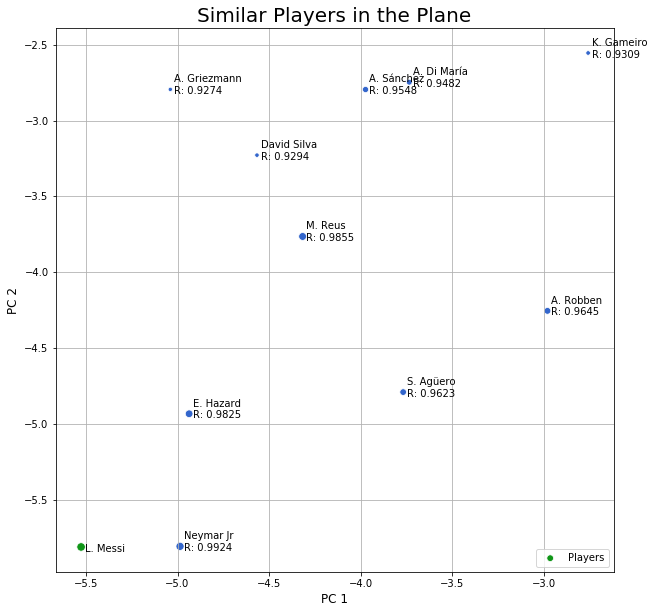

In [16]:
# Plot the N players most similar to 'L. Messi' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [17]:
# Show the N players most similar to 'L. Modrić' using cosine metric
target = 'L. Modrić'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
Thiago,0.9687
Dani Alves,0.9648
M. Götze,0.9605
David Silva,0.9481
Pizzi,0.9456
K. De Bruyne,0.9435
M. Pjanić,0.9397
A. Guardado,0.9378
Iniesta,0.9330
G. Bonaventura,0.9286


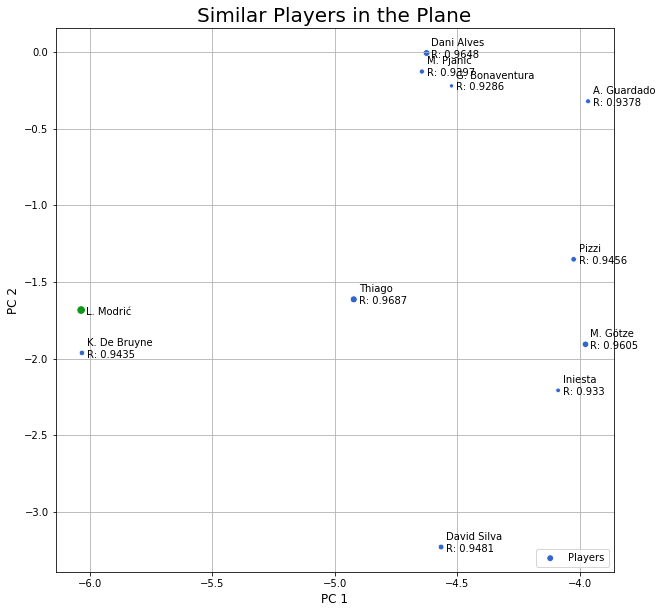

In [18]:
# Plot the N players most similar to 'L. Modrić' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [19]:
# Show the N players most similar to 'D. Godín' using cosine metric
target = 'D. Godín'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
G. Chiellini,0.9775
Miranda,0.9738
N. Otamendi,0.9694
S. Mustafi,0.9674
R. Varane,0.9621
Pepe,0.9592
V. van Dijk,0.9555
T. Alderweireld,0.9514
J. Boateng,0.9512
M. Benatia,0.9506


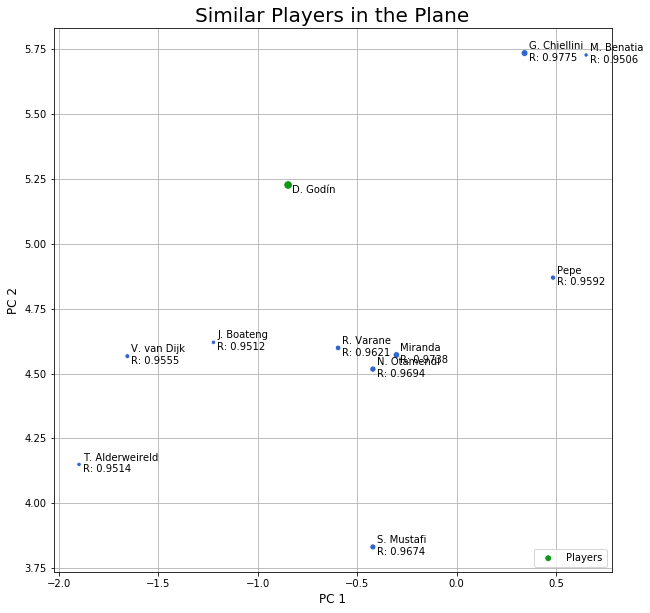

In [20]:
# Plot the N players most similar to 'D. Godín' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [21]:
# Show the N players most similar to 'De Gea' using cosine metric
target = 'De Gea'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
Casillas,0.9978
K. Navas,0.9975
H. Lloris,0.9964
J. Oblak,0.9936
Rui Patrício,0.9919
G. Buffon,0.9917
Pepe Reina,0.9916
M. Neuer,0.9913
Y. Sommer,0.9902
T. Courtois,0.9901


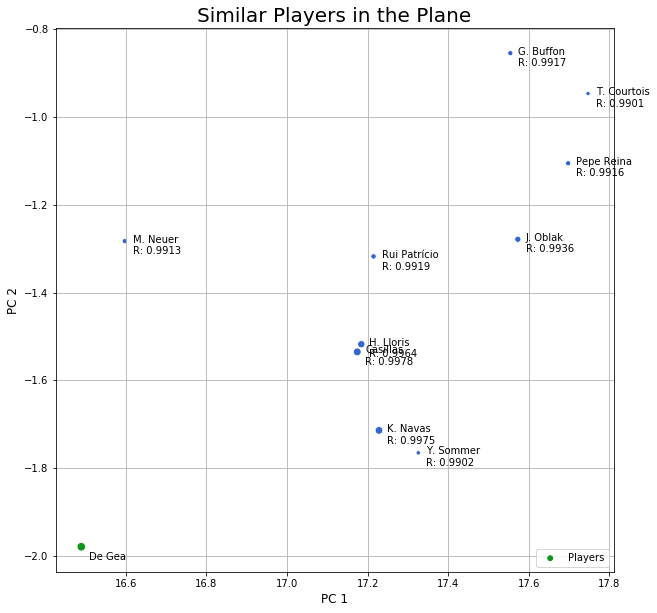

In [22]:
# Plot the N players most similar to 'De Gea' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

## Correlation matrix between Players

### Step 1 - Transpose the matrix by Players

In [23]:
pcaDF.head()

,PC1,PC2,PC3,PC4,PC5,Name
0,-5.526306,-5.808015,2.076504,2.350692,3.071319,L. Messi
1,-5.033655,-3.568653,4.896926,0.254852,4.140921,Cristiano Ronaldo
2,-4.986200,-5.803934,1.127417,1.682914,2.750608,Neymar Jr
3,16.489354,-1.978795,0.312424,2.100684,2.824599,De Gea
4,-6.030921,-1.962398,1.298546,2.143308,1.320396,K. De Bruyne


In [24]:
# Transpose the matrix
nPlayers = 50
tempDF = pcaDF.copy().head(nPlayers)
pcaDFT = tempDF.drop(['Name'], axis = 1).T
pcaDFT.columns = list(tempDF['Name'])
pcaDFT.head()

,L. Messi,Cristiano Ronaldo,Neymar Jr,De Gea,K. De Bruyne,E. Hazard,L. Modrić,L. Suárez,Sergio Ramos,J. Oblak,...,S. Handanovič,G. Buffon,S. Umtiti,M. Icardi,K. Koulibaly,P. Pogba,K. Navas,R. Lukaku,C. Immobile,Jordi Alba
PC1,-5.526306,-5.033655,-4.986200,16.489354,-6.030921,-4.936598,-6.034160,-4.291498,-3.698536,17.572773,...,18.035577,17.554175,-2.804312,-1.649098,2.191833,-5.438955,17.228313,-2.241988,-2.291223,-4.782408
PC2,-5.808015,-3.568653,-5.803934,-1.978795,-1.962398,-4.930870,-1.682930,-2.126353,3.403521,-1.278344,...,-0.494486,-0.854292,3.348890,-2.581644,6.717768,0.514912,-1.713776,-1.109442,-1.836816,0.297359
PC3,2.076504,4.896926,1.127417,0.312424,1.298546,0.985261,-0.712501,3.635059,1.141814,0.143841,...,1.146845,1.760154,-0.135030,2.624545,0.043987,2.585496,-0.248322,4.424802,3.096924,-2.382534
PC4,2.350692,0.254852,1.682914,2.100684,2.143308,1.042247,3.359507,1.426361,0.939394,0.435352,...,0.674164,2.322269,-0.242884,-2.193921,-1.299742,0.072369,1.424341,-2.284941,-1.859235,0.395377
PC5,3.071319,4.140921,2.750608,2.824599,1.320396,1.841818,1.979452,2.758875,2.542291,2.526036,...,1.839766,1.676578,1.193250,2.274901,0.921945,0.647842,2.221131,0.546272,1.184942,2.331787


### Step 2 - Calculate Pearson correlation matrix

$$ pearson(X, Y) = \frac{cov(X, Y)}{\sigma_X . \sigma_Y} = \frac{\sum_{i=1}^n (X_i - \bar{X}).(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2 . (Y_i - \bar{Y})^2}} $$

In [25]:
# Calculate the correlation matrix
corr = pcaDFT.corr(method = 'pearson')
corr.iloc[:10, :10]

,L. Messi,Cristiano Ronaldo,Neymar Jr,De Gea,K. De Bruyne,E. Hazard,L. Modrić,L. Suárez,Sergio Ramos,J. Oblak
L. Messi,1.000000,0.908333,0.996637,-0.385730,0.885932,0.999402,0.814337,0.934233,0.332183,-0.470835
Cristiano Ronaldo,0.908333,1.000000,0.892121,-0.503009,0.830084,0.918503,0.653822,0.977140,0.454924,-0.544258
Neymar Jr,0.996637,0.892121,1.000000,-0.329280,0.855786,0.995704,0.800578,0.909131,0.295869,-0.416183
De Gea,-0.385730,-0.503009,-0.329280,1.000000,-0.752732,-0.405158,-0.677299,-0.615761,-0.945480,0.992382
K. De Bruyne,0.885932,0.830084,0.855786,-0.752732,1.000000,0.891966,0.941467,0.925753,0.677389,-0.818650
E. Hazard,0.999402,0.918503,0.995704,-0.405158,0.891966,1.000000,0.818155,0.942326,0.357576,-0.487456
L. Modrić,0.814337,0.653822,0.800578,-0.677299,0.941467,0.818155,1.000000,0.774384,0.665971,-0.755309
L. Suárez,0.934233,0.977140,0.909131,-0.615761,0.925753,0.942326,0.774384,1.000000,0.538398,-0.668353
Sergio Ramos,0.332183,0.454924,0.295869,-0.945480,0.677389,0.357576,0.665971,0.538398,1.000000,-0.926766
J. Oblak,-0.470835,-0.544258,-0.416183,0.992382,-0.818650,-0.487456,-0.755309,-0.668353,-0.926766,1.000000


### Step 3 - Plot the correlation matrix

In [26]:
def plotCorrTriangle(corr):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    fig, ax1 = plt.subplots(figsize = (18, 18))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 240, n=9)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": .5})

    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment = 'right');

    # Add title
    ax1.set_title("Correlation Triangle", fontsize = 20)

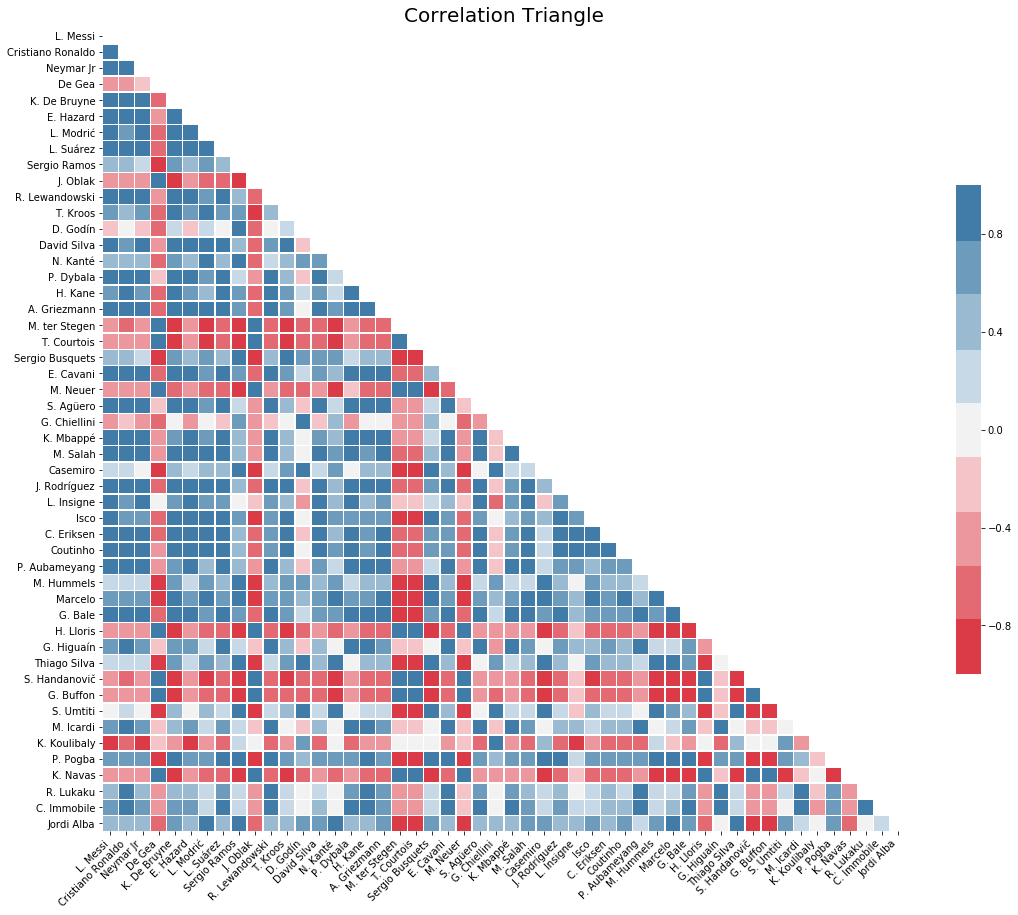

In [27]:
# Plot Correlation Triangle
plotCorrTriangle(corr)

## Insights

- The N players most similar to a specific player can be calculated, using the similarity functions.
- The results are directly related to the similarity function used.
- The matrix of correlation by individuals allows to see the correlation that exists between the players. It is the same item-item approach of the recommendation systems.

---
<a href="https://ansegura7.github.io/DataScience_FIFA19Data/">&laquo; Home</a>